## Подготовка

### загружаем библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
import time
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, LogisticRegression  
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### загружаем файл и выводим информацию

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)
print(data.head(15))

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12
2018-03-01 01:40:00          19
2018-03-01 01:50:00          25
2018-03-01 02:00:00          22
2018-03-01 02:10:00          12
2018-03-01 02:20:00          19


### делаем ресемплирование по 1 часу

In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

### смотрим информацию

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### смотрим максимальное и минимальное значение

In [5]:
data['num_orders'].max()

462

In [6]:
data['num_orders'].min()

0

### построим график

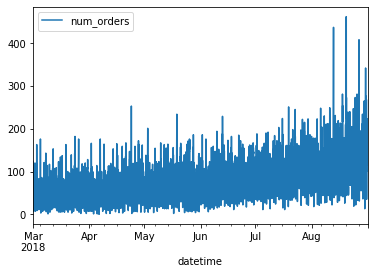

In [7]:
data.plot()

### посмотрим на выбросы

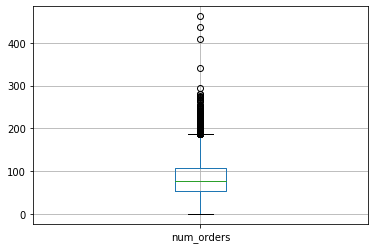

In [8]:
data.boxplot('num_orders')

видим что имеются выбросы, посмотрим много ли их

In [9]:
data[data['num_orders'] >= 180].count()

num_orders    148
dtype: int64

отсортируем, что бы посмотреть в какой день больше всего вызовов

In [10]:
data[data['num_orders'] >= 180].sort_values(by='num_orders',ascending=False).head(15)

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-25 00:00:00,273


привязать даты ни к чему не получается, да и выбросов маленькое количество, поэтому избавляемся от них

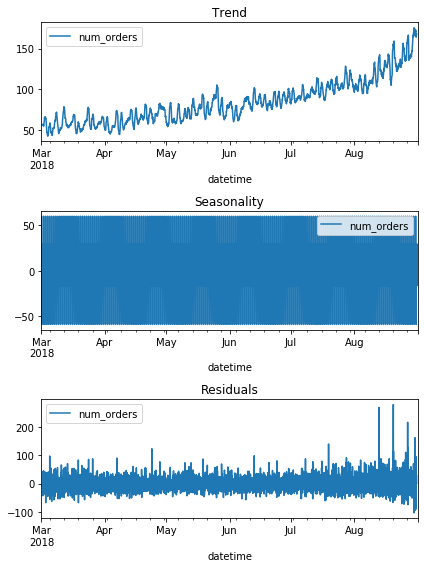

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

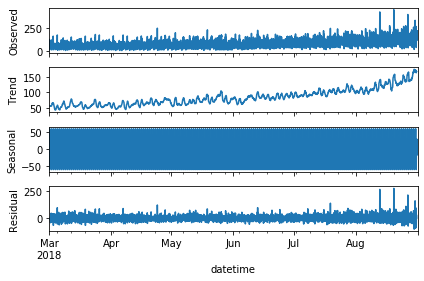

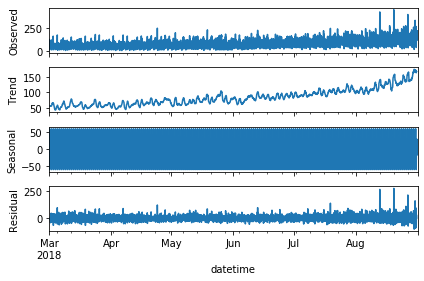

In [13]:
seasonal_decompose(data).plot()


### контрольная проверка
смотрим что бы выбросов больше не было

## Обучение

In [15]:
mse = mean_squared_error # зададим переменую

### напишем функцию для распределение
на год, месяц, день и день недели, так же сделаем смещение, и найдем скользящее среднее

In [16]:
def make_features(data, max_lag, rol_mean):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rol_mean).mean()
    
    

In [17]:
make_features(data, 1, 24)

In [18]:
data.sort_index(inplace=True)
data

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


разбиваем на выборке в соответствии с условием

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train.shape, test.shape)

(3974, 5) (442, 5)


### удаляем пропуски и разбиваем на признак и целевой признак

In [20]:
train = train.dropna()
#test = test.dropna()
    
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
    
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### напишем функцию для обучения моделей

In [21]:
def train_model (model):
    now = time.time()
    model.fit(features_train, target_train)
    time_fit = time.time() - now
    return time_fit

### обучим разные модели

In [22]:
lr = LinearRegression()
time_lr_fit = train_model(lr)
#time_lr_fit = time.time()
#lr.fit(features_train, target_train)
#time_lr_fit = time.time() - time_lr_fit

In [23]:
lgr = LogisticRegression()
time_lgr_fit = train_model(lgr)
#time_lgr_fit = time.time()
#lgr.fit(features_train, target_train)
#time_lgr_fit = time.time() - time_lgr_fit

In [24]:
lml = linear_model.Lasso()
time_lml_fit = train_model(lml)
#time_lml_fit = time.time()
#lml.fit(features_train, target_train)
#time_lr_fit = time.time() - time_lml_fit

### задаем параметры для кроссвалидации и зададим параметры

In [26]:
#cv = KFold(n_splits=3, shuffle=True, random_state=12345)
params = {
    'n_estimators': range (10, 151, 10),
    'max_depth': range (1,13, 2)
}

данный код закоментирован так как с ним возникла ощибка и решить её не получилось

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
def grid_model(model):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
    grid_model.fit(features_train, target_train)
    parameters = grid_model.best_params_
    return parameters

In [29]:
lgbm = LGBMRegressor()
lgbm_param = grid_model(lgbm)
time_lgbm_fit = time.time()
lgbm = LGBMRegressor(n_estimators=lgbm_param['n_estimators'], max_depth=lgbm_param['max_depth'], silent=True)
lgbm.fit(features_train, target_train)
time_lgbm_fit = time.time() - time_lgbm_fit

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  3.7min finished


In [30]:
rfc = RandomForestClassifier()
rfc_param = grid_model(rfc)
time_rfc_fit = time.time()
rfc = RandomForestClassifier(n_estimators=rfc_param['n_estimators'], max_depth=rfc_param['max_depth'])
rfc.fit(features_train, target_train)
time_rfc_fit = time.time() - time_rfc_fit

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  3.2min finished


In [31]:
rfr = RandomForestRegressor()
rfr_param = grid_model(rfr)
time_rfr_fit = time.time()
rfr = RandomForestRegressor(n_estimators=rfr_param['n_estimators'], max_depth=rfr_param['max_depth'])
rfr.fit(features_train, target_train)
time_rfr_fit = time.time() - time_rfr_fit

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.0min finished


## Тестирование

### напишем функцию для предсказания и rmse

In [38]:
def model_look(model, tiktak):
    now = time.time()
    pred = model.predict(features_test)
    pred_time = time.time() - now
    rmse = mse(target_test, pred)**(.5)
    return tiktak, pred_time, rmse

соберрем все данные в кучку

In [39]:
modelis = []
modelis.append(model_look(lr, time_lr_fit))
modelis.append(model_look(lgbm, time_lgbm_fit))
modelis.append(model_look(lgr, time_lgr_fit))
modelis.append(model_look(rfc, time_rfc_fit))
modelis.append(model_look(rfr, time_rfr_fit))
modelis.append(model_look(lml, time_lml_fit))

In [40]:
final_models = pd.DataFrame(data=modelis, index=['LinearRegression', 'LGBMRegressor', 'LogisticRegression', 'RandomForestClassifier',
                                                 'RandomForestRegressor', 'Lasso'], columns=['trainig_time', 'predic_time', 'RMSE'])

In [41]:
final_models

,trainig_time,predic_time,RMSE
LinearRegression,0.004311,0.002332,51.194081
LGBMRegressor,0.702380,0.005340,42.961078
LogisticRegression,4.546073,0.040548,70.285343
RandomForestClassifier,1.549449,0.246818,53.721251
RandomForestRegressor,0.520194,0.010731,46.179441
Lasso,0.035606,0.000925,51.201465


<div style="background: #e399ff; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='blue'><u><b>КОММЕНТАРИЙ Студента</b></u>
<font color='blue'><br>как круто все поменялось, после устранения ощибок<br>

In [42]:
def pred_tar(model, name):
    pred = model.predict(features_test)
    tar_test = target_test
    pred = pd.DataFrame(data=pred, columns=['predict'])
    tar_test = pd.DataFrame(data=target_test)
    sns.kdeplot(pred['predict'], shade=True)
    sns.kdeplot(tar_test['num_orders'], shade=True)
    plt.legend(['predict', 'target_test'])
    plt.title(name)

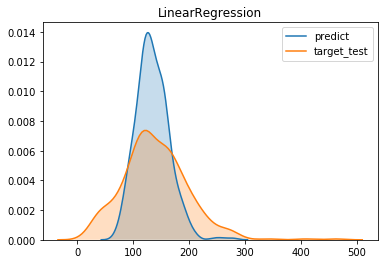

In [43]:
pred_tar(lr, "LinearRegression")


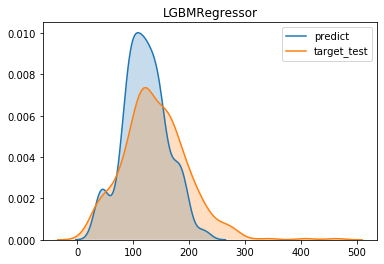

In [44]:
pred_tar(lgbm, "LGBMRegressor")

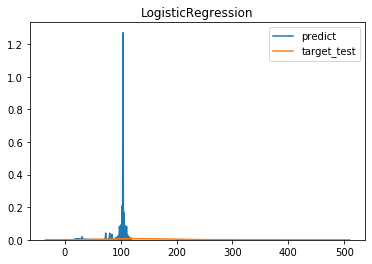

In [45]:
pred_tar(lgr, "LogisticRegression")

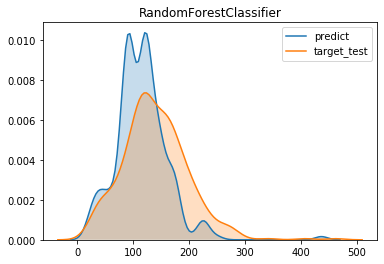

In [46]:
pred_tar(rfc, "RandomForestClassifier")

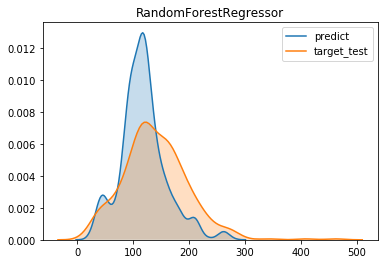

In [47]:
pred_tar(rfr, "RandomForestRegressor")

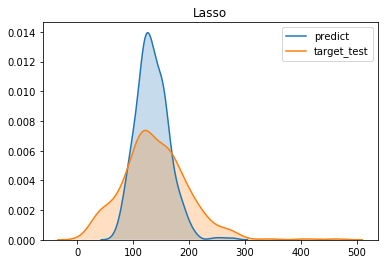

In [48]:
pred_tar(lml, "Lasso")

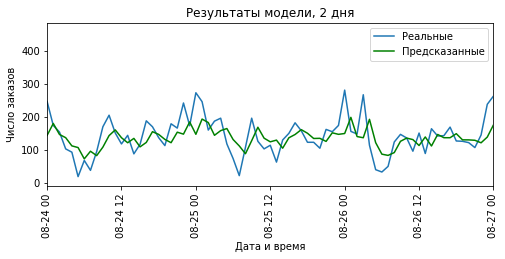

In [26]:
predictions = pd.Series(lr.predict(features_test))
predictions.index = target_test.index

fig2, ax = plt.subplots(figsize=(8, 3))
ax = sns.lineplot(data=target_test, label='Реальные')
sns.lineplot(data=predictions, color='green', label='Предсказанные')
plt.xticks(rotation=90)
#ax.set_xticklabels(features_test.dayofweek)
plt.xlim('2018-08-24', '2018-08-27')
plt.title('Результаты модели, 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов');